In [12]:
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from tqdm import tqdm

# Set up matplotlib for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [13]:
# Load the data with embeddings
def load_data_with_embeddings(file_path):
    """Load the JSONL file and extract embeddings"""
    data = []
    print(f"Loading data from {file_path}...")
    
    with open(file_path, 'r') as f:
        for line in tqdm(f):
            try:
                item = json.loads(line.strip())
                data.append(item)
            except json.JSONDecodeError:
                continue
    
    print(f"Loaded {len(data)} posts")
    return data

# Load the data
data = load_data_with_embeddings('data/data_with_embeddings.jsonl')

Loading data from data/data_with_embeddings.jsonl...


8799it [00:01, 8379.67it/s]

Loaded 8799 posts


In [14]:
# Extract embeddings and post information
print("Extracting embeddings and post information...")
embeddings = []
posts_info = []

for item in tqdm(data):
    if 'embedding' in item and item['embedding'] is not None:
        embeddings.append(item['embedding'])
        post_info = {
            'id': item.get('id', ''),
            'title': item.get('title', ''),
            'selftext': item.get('selftext', ''),
            'text_for_embedding': item.get('text_for_embedding', ''),
            'author': item.get('author', ''),
            'subreddit': item.get('subreddit', ''),
            'score': item.get('score', 0),
            'num_comments': item.get('num_comments', 0),
            'created_utc': item.get('created_utc', 0),
            'permalink': item.get('permalink', '')
        }
        posts_info.append(post_info)

# Convert to numpy array for clustering
embeddings_array = np.array(embeddings)
print(f"Shape of embeddings array: {embeddings_array.shape}")
print(f"Number of posts with embeddings: {len(posts_info)}")

Extracting embeddings and post information...


100%|██████████| 8799/8799 [00:00<00:00, 558415.51it/s]


Shape of embeddings array: (8799, 1024)
Number of posts with embeddings: 8799


Testing cluster numbers from 2 to 20...


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]


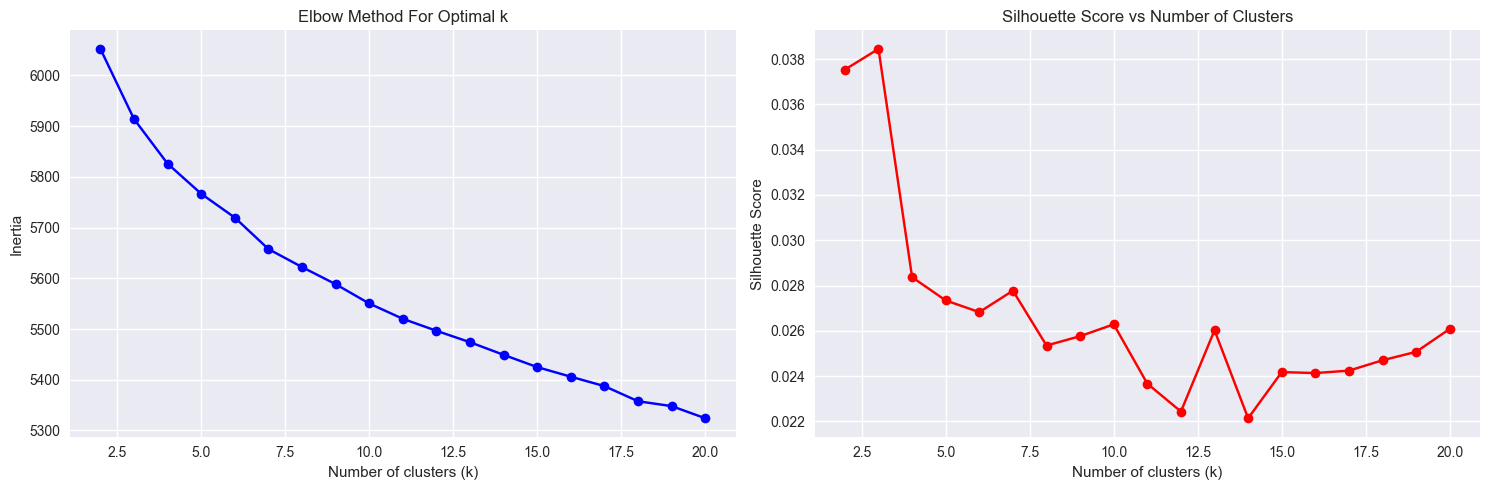

\nOptimal number of clusters based on silhouette score: 3
Silhouette score for k=3: 0.0385


In [15]:
# Determine optimal number of clusters using elbow method and silhouette score
def find_optimal_clusters(X, max_k=20, min_k=2):
    """Find optimal number of clusters using elbow method and silhouette score"""
    inertias = []
    silhouette_scores = []
    k_range = range(min_k, min(max_k + 1, len(X) // 2))  # Ensure we don't have more clusters than reasonable
    
    print(f"Testing cluster numbers from {min_k} to {max(k_range)}...")
    
    for k in tqdm(k_range):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(X, cluster_labels)
        silhouette_scores.append(sil_score)
    
    return list(k_range), inertias, silhouette_scores

# Find optimal clusters
k_values, inertias, sil_scores = find_optimal_clusters(embeddings_array)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(k_values, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method For Optimal k')
ax1.grid(True)

# Silhouette score plot
ax2.plot(k_values, sil_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find best k based on silhouette score
best_k_idx = np.argmax(sil_scores)
best_k = k_values[best_k_idx]
print(f"\\nOptimal number of clusters based on silhouette score: {best_k}")
print(f"Silhouette score for k={best_k}: {sil_scores[best_k_idx]:.4f}")

In [16]:
# Perform final clustering with optimal k

best_k=7
print(f"\\nPerforming K-means clustering with k={best_k}...")
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(embeddings_array)

# Add cluster labels to posts info
for i, post in enumerate(posts_info):
    post['cluster'] = int(cluster_labels[i])

print(f"Clustering completed!")
print(f"Cluster distribution:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} posts")

\nPerforming K-means clustering with k=7...
Clustering completed!
Cluster distribution:
  Cluster 0: 1447 posts
  Cluster 1: 1072 posts
  Cluster 2: 1713 posts
  Cluster 3: 1710 posts
  Cluster 4: 101 posts
  Cluster 5: 1107 posts
  Cluster 6: 1649 posts


In [17]:
# Create output directory for top posts per cluster
output_dir = Path("top20percluster")
output_dir.mkdir(exist_ok=True)

print(f"Creating files with top 20 posts per cluster in '{output_dir}' directory...")

# Group posts by cluster and get top 20 by score for each cluster
for cluster_id in range(best_k):
    # Get posts from this cluster
    cluster_posts = [post for post in posts_info if post['cluster'] == cluster_id]
    
    # Sort by score (descending) and take top 20
    top_posts = sorted(cluster_posts, key=lambda x: x['score'], reverse=True)[:20]
    
    # Create filename
    filename = output_dir / f"cluster_{cluster_id}_top20.json"
    
    # Save to file
    with open(filename, 'w') as f:
        json.dump({
            'cluster_id': cluster_id,
            'total_posts_in_cluster': len(cluster_posts),
            'top_20_posts': top_posts
        }, f, indent=2)
    
    print(f"  Cluster {cluster_id}: {len(cluster_posts)} total posts, top 20 saved to {filename}")

print(f"\\nAll files created successfully in '{output_dir}' directory!")

Creating files with top 20 posts per cluster in 'top20percluster' directory...
  Cluster 0: 1447 total posts, top 20 saved to top20percluster/cluster_0_top20.json
  Cluster 1: 1072 total posts, top 20 saved to top20percluster/cluster_1_top20.json
  Cluster 2: 1713 total posts, top 20 saved to top20percluster/cluster_2_top20.json
  Cluster 3: 1710 total posts, top 20 saved to top20percluster/cluster_3_top20.json
  Cluster 4: 101 total posts, top 20 saved to top20percluster/cluster_4_top20.json
  Cluster 5: 1107 total posts, top 20 saved to top20percluster/cluster_5_top20.json
  Cluster 6: 1649 total posts, top 20 saved to top20percluster/cluster_6_top20.json
\nAll files created successfully in 'top20percluster' directory!


In [18]:
# Analyze cluster characteristics
print("\\nCluster Analysis:")
print("="*50)

for cluster_id in range(best_k):
    cluster_posts = [post for post in posts_info if post['cluster'] == cluster_id]
    
    # Basic stats
    scores = [post['score'] for post in cluster_posts]
    avg_score = np.mean(scores) if scores else 0
    
    # Most common subreddits in this cluster
    subreddits = [post['subreddit'] for post in cluster_posts]
    subreddit_counts = {}
    for sub in subreddits:
        subreddit_counts[sub] = subreddit_counts.get(sub, 0) + 1
    
    top_subreddits = sorted(subreddit_counts.items(), key=lambda x: x[1], reverse=True)[:3]
    
    # Sample titles from top posts
    top_posts = sorted(cluster_posts, key=lambda x: x['score'], reverse=True)[:3]
    sample_titles = [post['title'][:100] + "..." if len(post['title']) > 100 else post['title'] 
                    for post in top_posts]
    
    print(f"\\nCluster {cluster_id}:")
    print(f"  Posts: {len(cluster_posts)}")
    print(f"  Average score: {avg_score:.2f}")
    print(f"  Top subreddits: {top_subreddits}")
    print(f"  Sample titles:")
    for i, title in enumerate(sample_titles, 1):
        print(f"    {i}. {title}")
        
print("\\n" + "="*50)
print(f"Analysis complete! Check the '{output_dir}' directory for individual cluster files.")

\nCluster Analysis:
\nCluster 0:
  Posts: 1447
  Average score: 108.73
  Top subreddits: [('Anarchism', 597), ('socialism', 556), ('Liberal', 109)]
  Sample titles:
    1. No mercy for Fascists
    2. Exposing the ridiculous anti-socialist tactics of shrewd capitalists
    3. High School Kids Organize Walkout Protest
\nCluster 1:
  Posts: 1072
  Average score: 405.46
  Top subreddits: [('Liberal', 367), ('democrats', 179), ('Conservative', 137)]
  Sample titles:
    1. Conservatives want a Reddit safe space
    2. Democrats May Shut Down Government to Keep Trump From Gutting It
    3. The United States of America and the people Vs. Donald J. Trump, and the GOP party
\nCluster 2:
  Posts: 1713
  Average score: 573.79
  Top subreddits: [('politics', 362), ('Conservative', 341), ('Republican', 297)]
  Sample titles:
    1. Nazi flags can fly in Utah schools, but not pride flags, GOP lawmaker says
    2. Elon Musk Says Team Behind CBS's '60 Minutes' Deserves 'A Long Prison Sentence'
    3.